## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

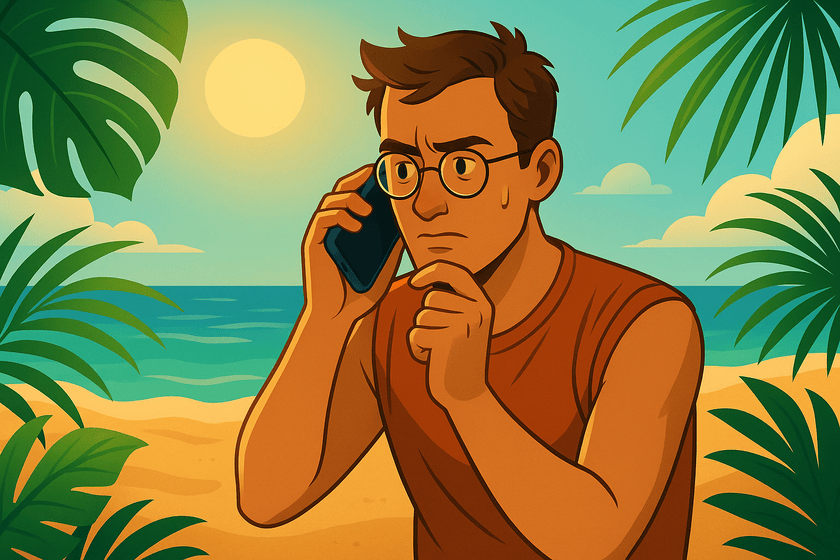

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

In [72]:
# importy

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support, cohen_kappa_score

In [73]:
# robię sobie skrót do mnist'a
mnist = tf.keras.datasets.mnist

# ładowanie zbioru danych
(x_train, y_train), (x_test, y_test) = mnist.load_data()

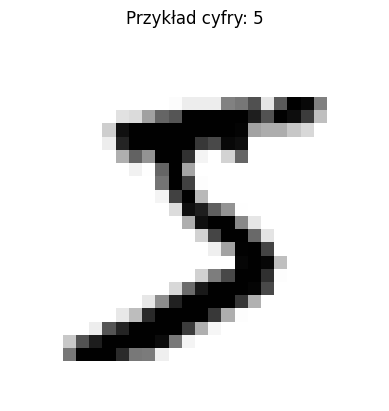

In [74]:
# wizualizacja przykładu

plt.imshow(x_train[0], cmap= plt.cm.binary) # zakładam, że nie potrzebujemy tutaj rozróżnienia na inne kolory niż białym i czarnym
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()

In [75]:
# używam print'a do zobaczenia takich surowych danych

print(x_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

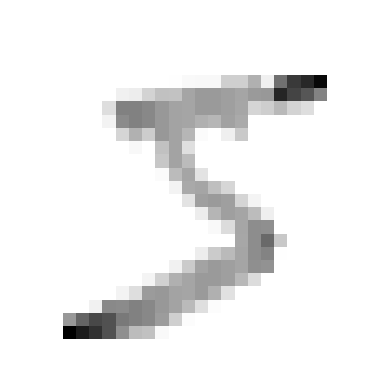

In [76]:
# wartości wachają się między 0 a 255, więc je po prostu znormalizuję skalując je do wartości miedzy 0 a 1

x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

print(x_train[0])

plt.imshow(x_train[0], cmap= plt.cm.binary)
plt.axis('off')
plt.show()

In [78]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten()) # warstwa wejściowa
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu)) # ukryta warstwa
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax)) # warstwa wyjściowa z wartością 10, ponieważ mamy łącznie 10 różnych liczb

model.compile(
    optimizer='adam', # pan z youtube powiedział, że to jest taki standardowy optimizer, więc ufam, że zadziała :>
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'] # będziemy mierzyć metrykę precyzji
)

model.fit(x_train, y_train, epochs=3)

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9219 - loss: 0.2680
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9661 - loss: 0.1089
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9761 - loss: 0.0741


In [79]:
# szacujemy precyzję modelu

val_loss, val_acc = model.evaluate(x_test, y_test)
print(val_loss, val_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9687 - loss: 0.1038
0.103795126080513 0.9686999917030334


------------------------------------------------------------------------------
**baseline model** 

In [80]:
# baseline'owy model (nie mam pojęcia czym miał się różnić od mojego, więc po prostu go zlobotomizowałam)

# piękny internet uświadomił mi, że warstwy można dodać od razu przy definiowaniu modelu
baseline_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation="softmax")
])

baseline_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

baseline_model.fit(x_train, y_train, epochs=3)

base_val_loss, base_val_acc = baseline_model.evaluate(x_test, y_test)
print(base_val_loss, base_val_acc)

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3390 - loss: 1.7375
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4999 - loss: 1.3400
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5669 - loss: 1.1889
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5849 - loss: 1.1384
1.1384350061416626 0.5849000215530396


^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
------------------------------------------------------------------------------
------------------------------------------------------------------------------

Pomyłki: 313 / 10000 = 3.13%


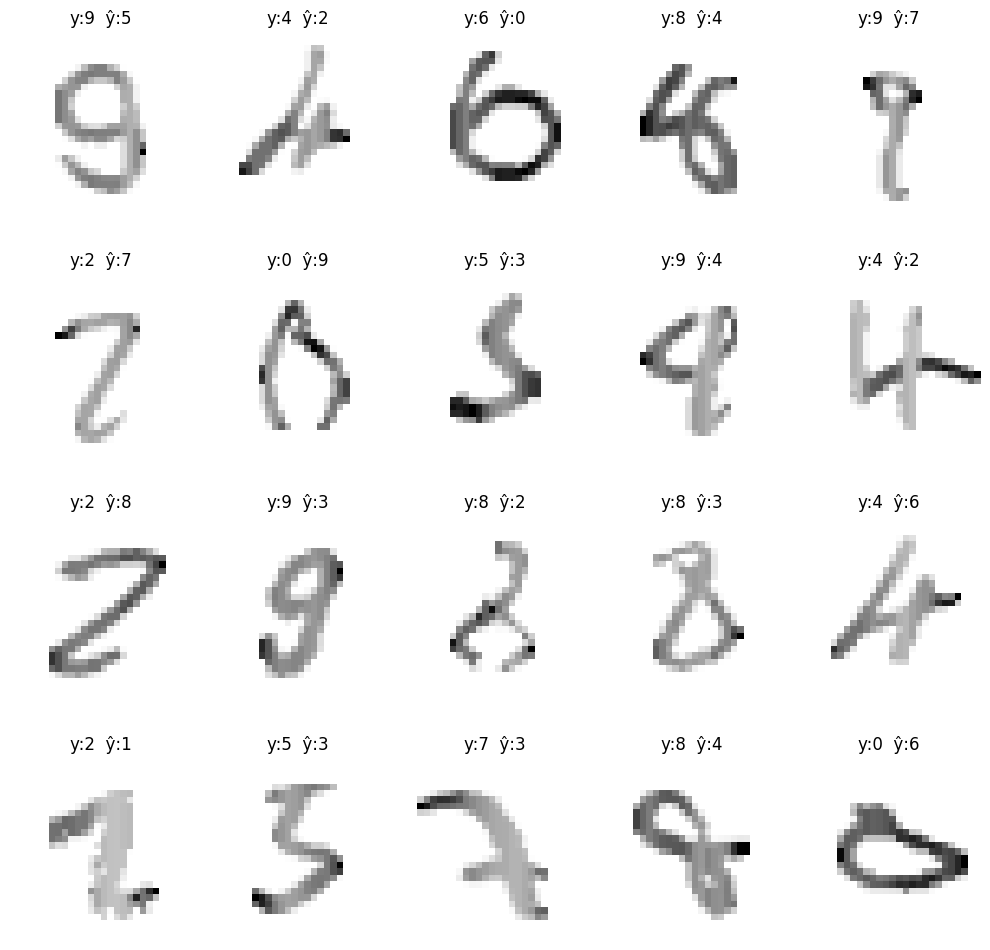

In [81]:
# ilość pomyłek i ich procent + wizualizacja 20 piewszych pomyłek

y_prob = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = y_test if y_test.ndim == 1 else np.argmax(y_test, axis=1)

loss, acc = model.evaluate(x_test, y_test, verbose=0)
mis_idx = np.where(y_pred != y_true)[0]
print(f"Pomyłki: {len(mis_idx)} / {len(y_true)} = {len(mis_idx)/len(y_true):.2%}")

n = min(20, len(mis_idx))
plt.figure(figsize=(10,10))
for i, idx in enumerate(mis_idx[:n]):
    plt.subplot(4, 5, i+1)
    plt.imshow(x_test[idx].squeeze(), cmap= plt.cm.binary)
    plt.title(f"y:{y_true[idx]}  ŷ:{y_pred[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [82]:
# raport % pomyłek na każdą liczbę

print("\nRaport klasyfikacji:")
print(classification_report(y_true, y_pred, digits=4))


Raport klasyfikacji:
              precision    recall  f1-score   support

           0     0.9857    0.9816    0.9836       980
           1     0.9817    0.9912    0.9864      1135
           2     0.9850    0.9545    0.9695      1032
           3     0.9207    0.9891    0.9537      1010
           4     0.9599    0.9745    0.9672       982
           5     0.9542    0.9574    0.9558       892
           6     0.9631    0.9802    0.9715       958
           7     0.9730    0.9815    0.9772      1028
           8     0.9808    0.9425    0.9613       974
           9     0.9853    0.9306    0.9572      1009

    accuracy                         0.9687     10000
   macro avg     0.9689    0.9683    0.9683     10000
weighted avg     0.9693    0.9687    0.9687     10000



In [83]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(10, activation="softmax")
])


model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model2.fit(x_train, y_train, epochs=5)

val_loss2, val_acc2 = model2.evaluate(x_test, y_test)
print(val_loss2, val_acc2)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8905 - loss: 0.3586
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9384 - loss: 0.2025
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9494 - loss: 0.1653
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9556 - loss: 0.1435
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9590 - loss: 0.1309
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9747 - loss: 0.0789
0.07889340817928314 0.9746999740600586


In [84]:
# oki, to teraz zrobię kolejny raport, ale do tego eksperymentalnego modelu

y_prob2 = model2.predict(x_test, verbose=0)
y_pred2 = np.argmax(y_prob2, axis=1)
y_true2 = y_test if y_test.ndim == 1 else np.argmax(y_test, axis=1)

print("\nRaport klasyfikacji drugiego modelu:")
print(classification_report(y_true2, y_pred2, digits=4))


Raport klasyfikacji drugiego modelu:
              precision    recall  f1-score   support

           0     0.9760    0.9939    0.9848       980
           1     0.9885    0.9859    0.9872      1135
           2     0.9777    0.9758    0.9767      1032
           3     0.9656    0.9723    0.9689      1010
           4     0.9815    0.9715    0.9765       982
           5     0.9829    0.9641    0.9734       892
           6     0.9842    0.9729    0.9785       958
           7     0.9663    0.9776    0.9720      1028
           8     0.9565    0.9713    0.9638       974
           9     0.9680    0.9594    0.9637      1009

    accuracy                         0.9747     10000
   macro avg     0.9747    0.9745    0.9745     10000
weighted avg     0.9748    0.9747    0.9747     10000



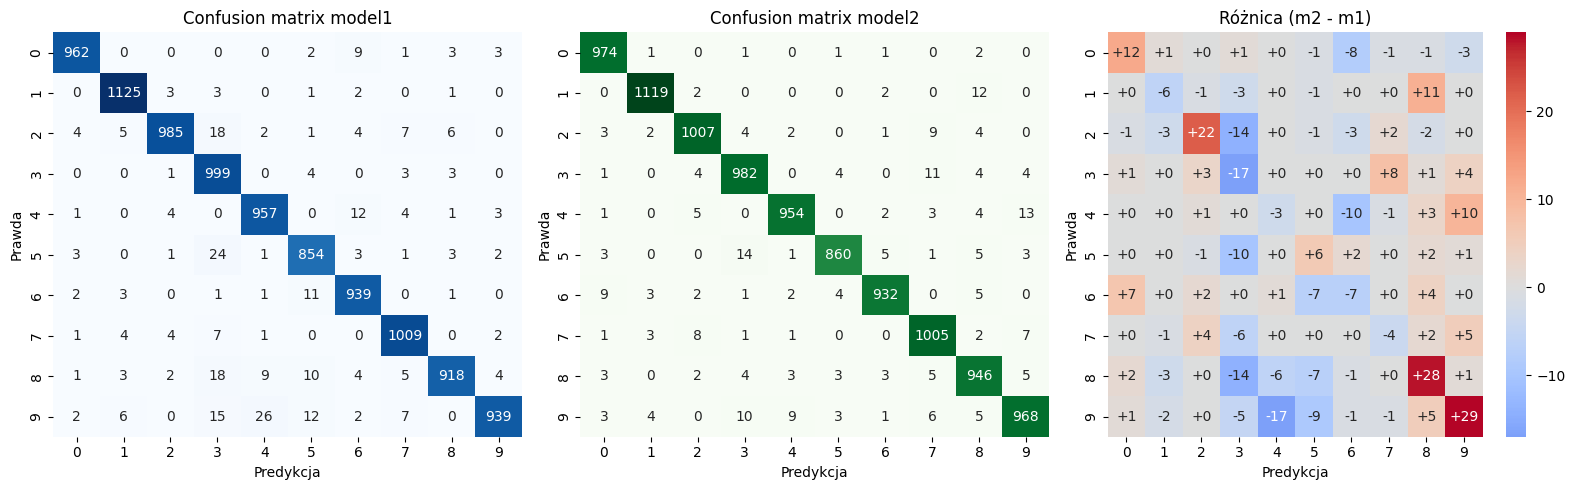

In [85]:
# heatmapa dla dwóch modeli, 

y_true = y_test if y_test.ndim == 1 else np.argmax(y_test, axis=1)
y_pred  = np.argmax(y_prob,  axis=1)
y_pred2 = np.argmax(y_prob2, axis=1)

cm1 = confusion_matrix(y_true, y_pred,  labels=range(10))
cm2 = confusion_matrix(y_true, y_pred2, labels=range(10))
cmd = cm2 - cm1

fig, axes = plt.subplots(1, 3, figsize=(16,5))

sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("Confusion matrix model1")
axes[0].set_xlabel("Predykcja")
axes[0].set_ylabel("Prawda")

sns.heatmap(cm2, annot=True, fmt="d", cmap="Greens", cbar=False, ax=axes[1])
axes[1].set_title("Confusion matrix model2")
axes[1].set_xlabel("Predykcja")
axes[1].set_ylabel("Prawda")

sns.heatmap(cmd, annot=True, fmt="+d", cmap="coolwarm", center=0, cbar=True, ax=axes[2])
axes[2].set_title("Różnica (m2 - m1)")
axes[2].set_xlabel("Predykcja")
axes[2].set_ylabel("Prawda")

plt.tight_layout()
plt.show()

In [86]:
acc1 = np.trace(cm1) / np.sum(cm1)
acc2 = np.trace(cm2) / np.sum(cm2)
print("Accuracy model1:", acc1)
print("Accuracy model2:", acc2)
print("Różnica:", acc2 - acc1)

Accuracy model1: 0.9687
Accuracy model2: 0.9747
Różnica: 0.006000000000000005


**Wychodzi na to, że model 2 wygrywa, ale nieznacznie xdd**